<a href="https://colab.research.google.com/github/Dhaneshkp/DesktopAssistant/blob/main/Imputation%20GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

Everst_data=pd.read_csv('Everest_data.csv')
data=Everst_data
data['Attained_age']=data['Age']+data['Duration']
data['Premium_rate']=data['BasePremiumAmount']/data['BaseNARAmount']*10000
exclude_cols = ['Gender','RiskClass']
Coulmns_to_keep=['Attained_age','Premium_rate']
data=data[data['SingleOrJointType']=="Single"]
data=data[data['Gender']=="Male"]
data=data[data['RiskClass']=="NS1"]
data=data[Coulmns_to_keep]
data['index']=data.index
numerical_columns = data.select_dtypes(include=['number']).columns
categorical_columns = data.select_dtypes(include=['object']).columns
data_copy=data.copy()
data.iloc[4::5, 1] = np.nan
test_data=data.head(64)
test_data_copy1=data_copy.head(64)
test_data

<ipython-input-63-8b5662100cf2>:6: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  Everst_data=pd.read_csv('Everest_data.csv')


,Attained_age,Premium_rate,index
0,41,3.795200,0
2,53,9.488000,2
4,59,22.345600,4
8,49,12.331262,8
9,60,NaN,9
...,...,...,...
87,38,NaN,87
88,51,10.646000,88
89,68,59.867200,89
91,63,37.416889,91


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # Add this line
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Assuming 'test_data' is your DataFrame with missing values in 'Premium_rate'
test_data_copy = test_data.copy()  # Create a copy to avoid modifying the original

# KNN Imputation
imputer_knn = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors
test_data_knn_imputed = pd.DataFrame(imputer_knn.fit_transform(test_data_copy), columns=test_data_copy.columns)
print("KNN Imputed Data:")
test_data_knn_imputed
# Iterative Imputation with Random Forest


KNN Imputed Data:


,Attained_age,Premium_rate,index
0,41.0,3.795200,0.0
1,53.0,9.488000,2.0
2,59.0,22.345600,4.0
3,49.0,12.331262,8.0
4,60.0,13.681354,9.0
...,...,...,...
59,38.0,8.073469,87.0
60,51.0,10.646000,88.0
61,68.0,59.867200,89.0
62,63.0,37.416889,91.0


In [ ]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score

class R2LoggingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, estimator=RandomForestRegressor()):
        self.estimator = estimator
        self.r2_scores = []

    def fit(self, X, y):
        self.estimator.fit(X, y)
        y_pred = self.estimator.predict(X)
        r2 = r2_score(y, y_pred)
        self.r2_scores.append(r2)
        return self

    def predict(self, X):
        return self.estimator.predict(X)

# Example usage:
imputer = IterativeImputer(estimator=R2LoggingRegressor(), max_iter=10, random_state=0)
imputed_data = imputer.fit_transform(test_data_copy.drop('index',axis=1))

# Print R2 scores for each iteration
print(imputer.estimator.r2_scores)
#imputer_iterative = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=0)
#test_data_iterative_imputed = pd.DataFrame(imputer_iterative.fit_transform(test_data_copy.drop('index',axis=1)), columns=test_data_copy.drop('index',axis=1).columns)
test_data_iterative_imputed = pd.DataFrame(imputed_data, columns=test_data_copy.drop('index',axis=1).columns)
print("\nIterative Imputed Data (Random Forest):")
test_data_iterative_imputed
#joined_data = test_data_copy.join(test_data_iterative_imputed, on = 'index', how='inner', lsuffix='_original', rsuffix='_imputed')
#joined_data

[]

Iterative Imputed Data (Random Forest):


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Attained_age,Premium_rate
0,41.0,3.795200
1,53.0,9.488000
2,59.0,22.345600
3,49.0,12.331262
4,60.0,24.915534
...,...,...
59,38.0,4.435077
60,51.0,10.646000
61,68.0,59.867200
62,63.0,37.416889


In [ ]:
# prompt: Using dataframe test_data_knn_imputed: show the nearest neigher and teh premium rate where the premium_rate_orig is nan, plot a graph of each premium rate and avearge of two nearest data points

import matplotlib.pyplot as plt

# Find rows where 'premium_rate_orig' is NaN
test_data_knn_imputed.sort_values(by='Attained_age', inplace=True)
nan_indices = test_data_knn_imputed['premium_rate_orig'].isna()
nan_rows = test_data_knn_imputed[nan_indices]

# Iterate over NaN rows and find nearest neighbors
for index, row in nan_rows.iterrows():
    # Calculate distances to all other points (excluding the current NaN row)
    distances = ((test_data_knn_imputed.drop(index) - row)**2).sum(axis=1)

    # Find the two nearest neighbors
    nearest_indices = distances.nsmallest(2).index

    nearest_rows = test_data_knn_imputed.loc[nearest_indices]
    average_premium_rate = (nearest_rows['premium_rate_orig'].mean())

    # Update the 'premium_rate_import' value for the current NaN row
    test_data_knn_imputed.at[index, 'premium_rate_import'] = average_premium_rate
    print(f"index {index} row {row} nearest_indices { nearest_indices} nearest rows {nearest_rows} average{average_premium_rate} ")

test_data_knn_imputed




index 9 row Attained_age         31.000000
Premium_rate          4.006886
premium_rate_orig          NaN
Name: 9, dtype: float64 nearest_indices Index([54, 26], dtype='int64') nearest rows     Attained_age  Premium_rate  premium_rate_orig
54          35.0      4.006886           6.534737
26          35.0      4.008439                NaN average6.5347368421052625 
index 26 row Attained_age         35.000000
Premium_rate          4.008439
premium_rate_orig          NaN
Name: 26, dtype: float64 nearest_indices Index([54, 23], dtype='int64') nearest rows     Attained_age  Premium_rate  premium_rate_orig  premium_rate_import
54          35.0      4.006886           6.534737                  NaN
23          35.0      4.005333           7.483600                  NaN average7.009168421052632 
index 7 row Attained_age         36.0000
Premium_rate          3.7944
premium_rate_orig        NaN
Name: 7, dtype: float64 nearest_indices Index([23, 54], dtype='int64') nearest rows     Attained_age  Pre

,Attained_age,Premium_rate,premium_rate_orig,premium_rate_import
40,21.0,4.952000,4.008439,NaN
33,26.0,4.005600,4.848800,NaN
9,31.0,4.006886,NaN,6.534737
42,35.0,2.529455,20.870679,NaN
26,35.0,4.008439,NaN,7.009168
...,...,...,...,...
62,63.0,37.416889,2.529455,NaN
61,68.0,59.867200,2.529600,NaN
18,68.0,44.900800,13.808000,NaN
49,69.0,52.384000,4.005600,NaN


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
!pip install pytorch-ignite
from ignite.engine import Engine, Events
from ignite.metrics import MeanSquaredError
from sklearn.preprocessing import PolynomialFeatures
# ...

def weighted_mse_loss(input, target, weight):
    return torch.mean(weight * (input - target) ** 2)

# Example data generation function
def generate_data(num_samples=1000):
    np.random.seed(0)
    age = np.random.randint(20, 60, size=num_samples)
    duration = np.random.randint(1, 20, size=num_samples)
    risk_class = np.random.randint(0, 3, size=num_samples)
    client_plan = np.random.randint(0, 4, size=num_samples)
    premium_rate = age * 0.1 + duration * 0.05 + risk_class * 1.5 + client_plan * 0.2 + np.random.normal(0, 1, size=num_samples)

    data = pd.DataFrame({
        'age': age,
        'duration': duration,
        'risk_class': risk_class,
        'client_plan': client_plan,
        'premium_rate': premium_rate
    })

    # Introduce random missing values in premium_rate
    missing_indices = np.random.choice(num_samples, size=int(0.1 * num_samples), replace=False)
    data.loc[missing_indices, 'premium_rate'] = np.nan

    return data

# Data Preparation
data = test_data
features = data[['Attained_age']].values
premium_rates = data['Premium_rate'].values

# Normalize features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()
features = scaler_X.fit_transform(features)
premium_rates = premium_rates.reshape(-1, 1)
premium_rates = scaler_y.fit_transform(premium_rates).reshape(-1)

# Create mask for missing values
mask = ~np.isnan(premium_rates)
premium_rates[~mask] = 0  # Replace NaNs with zeros for now

# Convert to tensors
features = torch.tensor(features, dtype=torch.float32)
premium_rates = torch.tensor(premium_rates, dtype=torch.float32).unsqueeze(1)
mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(1)

# Train a simple linear regression model
poly = PolynomialFeatures(degree=2)
features_poly = poly.fit_transform(features[mask.squeeze().bool()])
lin_reg = LinearRegression()
lin_reg.fit(features_poly, premium_rates[mask.squeeze().bool()])
lin_reg_predictions = lin_reg.predict(poly.fit_transform(features))

class Generator(nn.Module):
    def __init__(self, feature_dim, target_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(feature_dim + target_dim, 256),  # Increased neurons
            nn.LeakyReLU(0.2),  # LeakyReLU activation
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, target_dim),
            nn.ReLU()  # Ensure non-negative outputs
        )

    def forward(self, x, noise):
        input_combined = torch.cat((x, noise), dim=1)
        print(input_combined)
        return self.fc(input_combined)

class Discriminator(nn.Module):
    def __init__(self, feature_dim, target_dim):
        super(Discriminator, self).__init__()
        self.linear = nn.Linear(feature_dim, target_dim)  # Linear regression layer
        self.fc = nn.Sequential(
            nn.Linear(feature_dim + target_dim + target_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),  # Additional layer
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x, y):
        linear_prediction = self.linear(x)  # Linear regression prediction
        input_combined = torch.cat((x, y, linear_prediction), dim=1)  # Include prediction
        return self.fc(input_combined)

# Initialize models
feature_dim = features.shape[1]
target_dim = 1  # Premium rate is a single value
generator = Generator(feature_dim, target_dim)
discriminator = Discriminator(feature_dim, target_dim)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=0.02, betas=(0.5, 0.999))  # Increased
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.005, betas=(0.5, 0.999))

# Loss functions
reconstruction_loss = nn.MSELoss()
regression_loss = nn.MSELoss()

# Gradient penalty
def compute_gradient_penalty(discriminator, real_samples, fake_samples, real_features):
    alpha = torch.rand(real_samples.size(0), 1)
    alpha = alpha.expand(real_samples.size()).to(real_samples.device)

    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = discriminator(real_features, interpolates)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(d_interpolates.size()).to(real_samples.device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

weights = torch.ones_like(premium_rates)
weights[~mask.squeeze().bool()] = 100.0  # Adjust weight as needed
# Training loop
num_epochs = 1000
batch_size = 64
lambda_gp = 10  # Gradient penalty coefficient
critic_iterations = 10  # Number of discriminator updates per generator update

for epoch in range(num_epochs):
    for _ in range(critic_iterations):
        # Generate fake data
        noise = torch.randn(batch_size, target_dim)

        # Create batches (replace with your data loading logic)
        batch_indices = np.random.choice(len(features), batch_size, replace=False)
        real_features = features[batch_indices]
        real_premium_rates = premium_rates[batch_indices]
        batch_mask = mask[batch_indices]
        lin_reg_preds = torch.tensor(lin_reg_predictions[batch_indices], dtype=torch.float32).unsqueeze(1)

        # Generate fake targets using the generator
        lin_reg_preds_tensor = torch.tensor(lin_reg.predict(poly.fit_transform(real_features)), dtype=torch.float32)
        combined_input = lin_reg_preds_tensor + noise
        fake_premium_rates = generator(real_features, combined_input)


        # Combine real and fake targets using the mask
        combined_premium_rates = batch_mask * real_premium_rates + (1 - batch_mask) * fake_premium_rates

        # Train Discriminator
        d_optimizer.zero_grad()

        real_validity = discriminator(real_features, real_premium_rates)
        fake_validity = discriminator(real_features, combined_premium_rates.detach())

        gradient_penalty = compute_gradient_penalty(discriminator, real_premium_rates, combined_premium_rates, real_features)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        d_optimizer.step()

    # Train Generator
    g_optimizer.zero_grad()

    noise = torch.randn(batch_size, target_dim)
    lin_reg_preds_tensor = torch.tensor(lin_reg.predict(poly.fit_transform(real_features)), dtype=torch.float32)
    combined_input = lin_reg_preds_tensor + noise
    fake_premium_rates = generator(real_features, combined_input)
    combined_premium_rates = batch_mask * real_premium_rates + (1 - batch_mask) * fake_premium_rates
    #lin_reg_preds=batch_mask * real_premium_rates+(1 - batch_mask) * lin_reg_preds
    g_loss_adv = -torch.mean(discriminator(real_features, combined_premium_rates))
    g_loss_recon = reconstruction_loss(combined_premium_rates, real_premium_rates)
    g_loss_reg = weighted_mse_loss(combined_premium_rates, lin_reg_preds, weights[batch_indices])
    g_loss = g_loss_adv + g_loss_recon + g_loss_reg

    g_loss.backward()
    g_optimizer.step()

    if epoch % 100== 0:
        print(f'Epoch [{epoch}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')

# Use the trained generator for imputation
noise = torch.randn(len(features), target_dim)
lin_reg_preds_tensor = torch.tensor(lin_reg.predict(poly.fit_transform(features)), dtype=torch.float32)
combined_input = lin_reg_preds_tensor + noise
imputed_premium_rates = generator(features, combined_input).detach().numpy()
imputed_premium_rates = mask.numpy() * premium_rates.numpy() + (1 - mask.numpy()) * imputed_premium_rates

# Denormalize the imputed values
imputed_premium_rates = scaler_y.inverse_transform(imputed_premium_rates)

# Replace the original missing values with the imputed values
data['imputed_premium_rate'] = imputed_premium_rates
data


Streaming output truncated to the last 5000 lines.
        [ 1.7987,  2.5296],
        [-1.1216, -0.9672],
        [-0.1796, -2.3172],
        [ 1.7987,  3.3008],
        [-0.7448, -2.8471],
        [-2.1579,  0.5230],
        [-0.9332, -0.1766],
        [-1.3101, -1.2948]])
tensor([[-1.3101, -0.7543],
        [ 1.3277,  1.3935],
        [ 1.3277,  2.7240],
        [-0.9332, -0.3469],
        [-1.3101, -0.0502],
        [ 1.8930,  2.7245],
        [ 1.7987,  2.5572],
        [-0.2738, -0.1484],
        [ 0.1972,  0.8468],
        [ 0.3857, -0.6634],
        [-0.0854, -1.4088],
        [ 0.1972,  0.0199],
        [-0.7448, -1.8733],
        [ 0.8567,  1.8243],
        [-1.3101, -1.4421],
        [-1.0274, -1.2105],
        [-1.1216, -0.2163],
        [-0.0854, -1.6133],
        [-1.3101,  0.2338],
        [-0.4622, -0.5789],
        [ 0.1972, -0.3060],
        [-0.1796, -2.5895],
        [ 0.0088, -0.4837],
        [-0.6506, -1.6860],
        [ 2.1756,  3.9901],
        [ 0.5741, -0.694

,Attained_age,Premium_rate,imputed_premium_rate
0,41,3.795200,3.795200
2,53,9.488000,9.488000
4,59,22.345600,22.345600
8,49,12.331262,12.331263
9,60,NaN,15.518521
...,...,...,...
87,38,NaN,15.518521
88,51,10.646000,10.646000
89,68,59.867200,59.867199
91,63,37.416889,37.416889


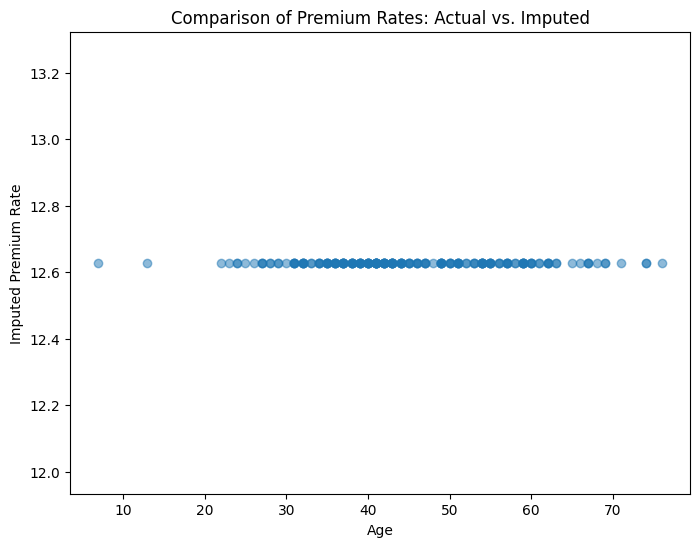

In [ ]:
# @title Comparison of Premium Rates: Actual vs. Imputed

import matplotlib.pyplot as plt
data_imputed=data[data['Premium_rate'].isnull()]
plt.figure(figsize=(8, 6))
plt.scatter(data_imputed['Attained_age'], data_imputed['imputed_premium_rate'], alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Imputed Premium Rate')
_ = plt.title('Comparison of Premium Rates: Actual vs. Imputed')

In [ ]:
import sklearn.metrics as metrics

lin_reg = LinearRegression()
lin_reg.fit(features[mask.squeeze().bool()], premium_rates[mask.squeeze().bool()])
lin_reg_predictions = lin_reg.predict(features)

# Calculate Mean Squared Error (MSE) as Loss
mse_loss = metrics.mean_squared_error(premium_rates[mask.squeeze().bool()], lin_reg_predictions[mask.squeeze().bool()])

# Calculate R-squared (R2) score
r2_score = metrics.r2_score(premium_rates[mask.squeeze().bool()], lin_reg_predictions[mask.squeeze().bool()])

print("MSE Loss:", mse_loss)
print("R2 Score:", r2_score)

MSE Loss: 0.4059527
R2 Score: 0.5940473375098508
